<a href="https://colab.research.google.com/github/leohpark/Files/blob/main/GPT_4_Turbo_Long_Context_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-4 Turbo Long Context Analyzer


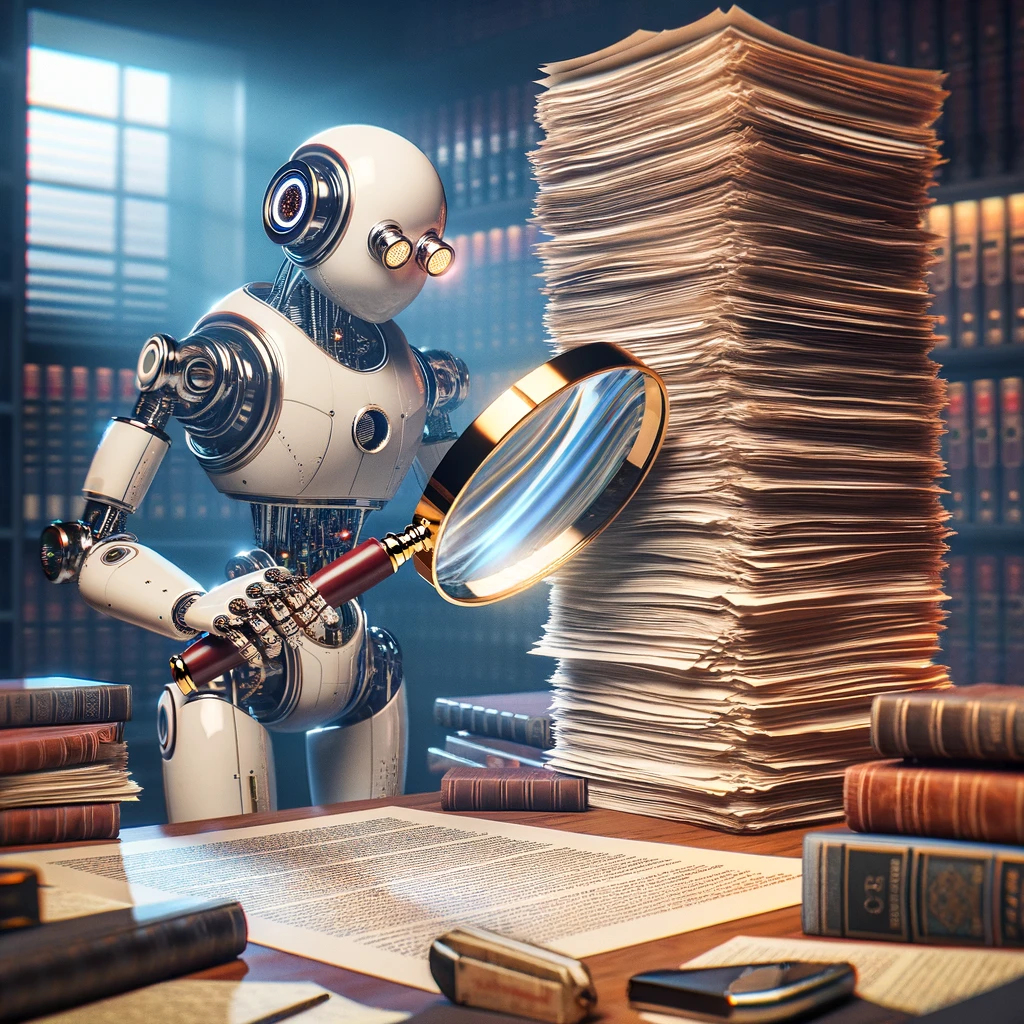

## Disclaimer
Unless required by applicable law or agreed to in writing, the code provided in this notebook is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

## GPT-4 Turbo Long Context Analyzer

This is a Playground-style analyzer that allows you to test the performance of gpt-4-1106-preview more holistically for legal domain tasks. Recent experiments regarding the new 128k context window model have focused on "Needle in Haystack" style in context retrieval tasks. I was more interested in seeing what happens when a complex task is given to the model in conjunction with a context full of unrelated information.

This Notebook allows you to define a System Prompt with an templated Query (user question or task). After this chat history entry, you can configure any of the following:
- Up to 93700 tokens from the Federal Rules of Civil Procedure.
- Your uploaded Documents, obviously required for gpt to complete the task, but you can include relevant and non-relevant documents, which will be included in the context in the order they are selected from the drop-down.
- Up to 42800 tokens from the Federal Rules of Appellate Procedure.
- Up to 26300 tokens from the Federal Rules of Evidence.

The FRCP, FRAP, and FRE are initially fetched via URL the first time you make a call, and the extracted text will be cached locally in Colab for subsequent calls made during the same session.

There are some guardrails and error-catching around calls. You must include at least one uploaded document, some user question, a valid API key, and your entire request must be less than 128,000 tokens in length. The "Total Tokens" window will keep a running tally of your "total_tokens" which includes prompt templates and max_tokens. Even though gpt may not use all of these reserved tokens, they need to be reserved before sending the call.

There are probably a good number of bugs in here I haven't caught around weird states and bad call assemblage, please excuse the possible mess!

Once you have received your results, the responses are logged locally to a file called "log_file.txt" which accessible from the second tab. Here, you can see previous API responses, as well as input token details and final output tokens as reported by the API.

Note: This file is stored in Colab, and well be deleted when your runtime is disconnected. You must store it locally, and re-upload it if you wish to access it again.

In [ ]:
!pip install -q gradio langchain unstructured pdf2image openai tiktoken pdfminer.six unstructured_inference unstructured_pytesseract

In [ ]:
import gradio as gr
from langchain.llms import OpenAI
from langchain.document_loaders import UnstructuredPDFLoader, OnlinePDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain import PromptTemplate
from langchain.docstore import document
from gradio import context
import tiktoken
import openai
import json
import urllib, os

## Utility Functions

In [ ]:
def tiktoken_len(text):
    tokenizer = tiktoken.get_encoding('cl100k_base')
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

def pdf_loader(files):
    loader = UnstructuredPDFLoader(files)
    loader_doc = loader.load()
    doc_text = loader_doc[0].page_content[:]
    doc_tokens = tiktoken_len(doc_text)

    return doc_text, doc_tokens

def online_pdf_loader(url):
    # Extract the filename from the URL
    filename = url.split('/')[-1]
    text_path = f'/content/{filename}.txt'

    # Check if the text file already exists
    if os.path.exists(text_path):
        with open(text_path, 'r') as file:
            doc_text = file.read()
    else:
        # If the text file doesn't exist, download and process the PDF
        loader = OnlinePDFLoader(url)
        loader_doc = loader.load()
        doc_text = loader_doc[0].page_content[:]

        # Save the text content locally
        with open(text_path, 'w') as file:
            file.write(doc_text)

    # Process the content to get tokens
    doc_tokens = tiktoken_len(doc_text)

    return doc_text, doc_tokens

def text_splitter(doc, max_tokens=1000):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = int(max_tokens), #chunk_s, # number of units per chunk
        chunk_overlap = 0, # number of units of overlap
        length_function = tiktoken_len, #use tokens as chunking unit instead of characters.
        separators=[' ', ''] # our chosen operators for separating
        )
    texts = text_splitter.split_text(doc)
    return texts

#frpc_pdf = 93718 tokens, frap_pdf = 42804, fre_pdf = 26330
frcp_pdf = "https://www.uscourts.gov/sites/default/files/federal_rules_of_civil_procedure_december_1_2022_0.pdf"
frap_pdf = "https://www.uscourts.gov/sites/default/files/rules-of-appellate-procedure.pdf"
fre_pdf = "https://www.uscourts.gov/sites/default/files/federal_rules_of_evidence_-_dec_1_2019_0.pdf"

## Prompt Library Globals

In [ ]:
#system_message template without brackets is 71 tokens. doc_template without brackets is 9 tokens.

system_message_template = """You are a helpful and experienced research attorney. Analyze the Documents and answer the Query below
using only information found in the Documents. Be thorough and careful, and answer as completely as you can. Do not make up facts for your answer.
If an answer is not provided within the Documents then respond that the answer could not be found.

Query:
{user_question}"""

doc_template = """####Document####

{retrieved_text}

####End of Document####"""


## LLM Call and Chat History Builder functions

In [ ]:
def context_maker(doc_link, context):
  my_doc, doc_tokens = online_pdf_loader(doc_link)
  if context <= doc_tokens:
    my_chunks = text_splitter(my_doc, context)
  else:
    my_chunks = text_splitter(my_doc, doc_tokens)
  test_chunk = my_chunks[0]
  formatted_sample = doc_template.format(retrieved_text=test_chunk)

  return formatted_sample

def large_llm_call(user_settings, doc_text, frcp_sample=None, frap_sample=None, fre_sample=None):
    openai.api_key = user_settings['openai_key']
    chat_history = []
    final_message = user_settings["system_message"].format(user_question=user_settings["user_question"])

    if user_settings['system_message']:
        chat_history.append({"role": "system", "content": final_message})
    if frcp_sample:
        chat_history.append({"role": "system", "content": frcp_sample})
    for doc in doc_text:
        chat_history.append({"role": "system", "content": doc})
    if frap_sample:
        chat_history.append({"role": "system", "content": frap_sample})
    if fre_sample:
        chat_history.append({"role": "system", "content": fre_sample})
#    chat_history.append({"role": "system", "content": user_settings['user_prompt']})

    response = openai.chat.completions.create(
        model=user_settings['llm_choice'],
        messages = chat_history,
        temperature=user_settings['temperature'],
        max_tokens=user_settings['max_tokens'],
        top_p=user_settings['top_p'],
        frequency_penalty=user_settings['frequency_penalty'],
        presence_penalty=user_settings['presence_penalty'],
        seed=user_settings['seed']
    )
    #response by itself is not serializabel. fix it.
    response_message = response.choices[0].message.content
    return response_message, response

def append_to_log(user_settings, response):
    log_entry = {
        "system_message": user_settings['system_message'],
        "user_question": user_settings['user_question'],
        "llm_response_id": response.id,
        "llm_response_kind": response.object,
        "llm_message": response.choices[0].message.content,
        "llm_model": response.model,
        "llm_completion_tokens": response.usage.completion_tokens,
        "llm_prompt_tokens": response.usage.prompt_tokens,
        "llm_total_tokens": response.usage.total_tokens,
        "tokens_dict": user_settings['tokens_dict']
    }

    # Write the new log entry
    with open(log_file_path, 'a') as log_file:
        json.dump(log_entry, log_file)
        log_file.write('\n')

    # Read all log entries and extract llm_response_id
    llm_response_ids = []
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            try:
                log_entry = json.loads(line)
                llm_response_ids.append(log_entry['llm_response_id'])
            except json.JSONDecodeError:
                pass  # Skip lines that can't be decoded as JSON

    return llm_response_ids

def get_response_ids():
    llm_response_ids = []
    try:
        with open(log_file_path, 'r') as log_file:
            for line in log_file:
                try:
                    log_entry = json.loads(line)
                    llm_response_ids.append(log_entry['llm_response_id'])
                except json.JSONDecodeError:
                    pass  # Skip lines that can't be decoded as JSON
    except FileNotFoundError:
        # If the file does not exist, you can choose to return an empty list
        # or a specific message indicating the file is not found.
        print(f"No log file found at {log_file_path}")

    return gr.Dropdown(choices=llm_response_ids)

def get_log_entries(llm_id):
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            try:
                log_entry = json.loads(line)
                if log_entry['llm_response_id'] == llm_id:
                    # Extracting required information
                    past_run_stats = {
                        "llm_model": log_entry['llm_model'],
                        "llm_total_tokens": log_entry['llm_total_tokens'],
                        "tokens_dict": log_entry['tokens_dict']
                    }
                    past_question = log_entry['user_question']
                    past_answer = log_entry['llm_message']
                    return past_run_stats, past_question, past_answer
            except json.JSONDecodeError:
                pass  # Skip lines that can't be decoded as JSON

    # Return None or appropriate values if the llm_id is not found
    return None, None, None

## Frontend to Backend Functions

In [ ]:
#GLOBAL Variable to manage docs_context choices
log_file_path = '/content/log_file.txt'
uploaded_docs = []
uploaded_doc_names = []

#inputs=[file_tokens, max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox, fre_context,
#                                                   system_message, user_question, outputs=total_tokens)
def update_token_count(max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
                       fre_context, system_message, user_question, uploaded_docs, docs_for_context):
  user_tokens = 0
  pre_tokens = 0
  doc_tokens = 0
  post_tokens = 0
  total_tokens = 0

  total_tokens += max_tokens
  # "9" here is a hardcoded value for the tokens added by doc_template
  if frcp_checkbox:
    pre_tokens += (int(frcp_context) + 9)
  if frap_checkbox:
    post_tokens += (int(frap_context) + 9)
  if fre_checkbox:
    post_tokens += (int(fre_context) + 9)
  if system_message:
    user_tokens += tiktoken_len(system_message)
  if user_question:
    user_tokens += tiktoken_len(user_question)
  if docs_for_context:
    doc_texts = doc_to_text(docs_for_context, uploaded_docs)
    for doc in doc_texts:
      doc_tokens += (tiktoken_len(doc) + 9)
    total_tokens = max_tokens + user_tokens + pre_tokens + doc_tokens + post_tokens


  tokens_dictionary = {
      "user_tokens": user_tokens,
      "pre_tokens": pre_tokens,
      "doc_tokens": doc_tokens,
      "post_tokens": post_tokens,
      "total_tokens": total_tokens,
  }

  return json.dumps(tokens_dictionary)

def doc_to_text(doc_names, uploaded_docs):
    docs_list = uploaded_docs
    doc_context = []

    for name in doc_names:
        for doc in docs_list:
            if doc.metadata.get('source', '').endswith(name):
                page_content = doc.page_content
                formatted_content = doc_template.format(retrieved_text=page_content)
                doc_context.append(formatted_content)
                break  # Found a match, no need to continue searching
    return doc_context

def files_to_text(files):
    imported_docs = []

    if files is not None:
        for file in files:
            loader = UnstructuredPDFLoader(file.name)
            uploaded_doc = loader.load()

            for doc in uploaded_doc:
                imported_docs.append(doc)

    return imported_docs

def files_to_names(files):
    metadata_sources = []
    file_names = []

    if files is not None:
        for file in files:
            loader = UnstructuredPDFLoader(file.name)
            uploaded_doc = loader.load()

            for doc in uploaded_doc:
                metadata_sources.append(doc.metadata.get('source', ''))

        file_names = [source.split("/")[-1] for source in metadata_sources]
    return gr.Dropdown(choices=file_names)

def files_to_token_length(files):
    total_token_length = 0

    if files is not None:
        for file in files:
            loader = UnstructuredPDFLoader(file.name)
            uploaded_doc = loader.load()

            for doc in uploaded_doc:
                # Calculates token length of documents being introduced
                token_length = tiktoken_len(doc.page_content)
                total_token_length += token_length

    return total_token_length

def get_answer_function(openai_key, llm_choice, max_tokens, temperature, seed, top_p, frequency_penalty,
               presence_penalty, system_message, user_question, uploaded_docs, docs_for_context, frcp_checkbox,
               frcp_context, frap_checkbox, frap_context, fre_checkbox, fre_context, total_tokens):
    tokens_dict = json.loads(total_tokens)


    if not docs_for_context:
        raise gr.Error("You have not selected any Documents to include in the context.")

    # Check if user_question is empty
    if not user_question.strip():
        raise gr.Error("The User Question field is empty.")

    # Check if openai_key is empty
    if not openai_key.strip():
        raise gr.Error("The OpenAI API key is missing.")

    if int(tokens_dict['total_tokens']) > 127999:
        raise gr.Error("Your total tokens exceeds the model context length.")

    if openai_key:
        openai.api_key = openai_key
        try:
            my_models = openai.models.list()
        except openai.AuthenticationError as e:
            raise gr.Error(e)


    tokens_dict = json.loads(total_tokens)
    user_settings = {
        "openai_key": openai_key,
        "llm_choice": llm_choice,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "seed": int(seed),
        "top_p": top_p,
        "frequency_penalty": frequency_penalty,
        "presence_penalty": presence_penalty,
        "system_message": system_message,
        "user_question": user_question,
        "docs_for_context": docs_for_context,
        "frcp_checkbox": frcp_checkbox,
        "frcp_context": frcp_context,
        "frap_checkbox": frap_checkbox,
        "frap_context": frap_context,
        "fre_checkbox": fre_checkbox,
        "fre_context": fre_context,
        "tokens_dict": tokens_dict,
    }
    #assemble docs
    doc_text = doc_to_text(docs_for_context, uploaded_docs)

    frcp_sample = ""
    frap_sample = ""
    fre_sample = ""
    #assemble rules contexts
    if frcp_checkbox:
      frcp_sample = context_maker(frcp_pdf, frcp_context)
    if frap_checkbox:
      frap_sample = context_maker(frap_pdf, frap_context)
    if fre_checkbox:
      fre_sample = context_maker(fre_pdf, fre_context)

    #send API call
    response_content, response = large_llm_call(user_settings, doc_text, frcp_sample, frap_sample, fre_sample)
    #log result
    llm_ids = append_to_log(user_settings, response)

    return response_content, gr.Dropdown(choices=llm_ids)

## Gradio Blocks

In [ ]:
with gr.Blocks(theme=gr.themes.Soft()) as demo:
  with gr.Tab('Files, GPT Settings, and Prompts'):
    with gr.Row():
      with gr.Column(scale=1):
        uploaded_docs = gr.State()
        files = gr.File(label='Upload Files', file_count='multiple', file_types=['.pdf'])
        file_tokens = gr.Textbox(lines=1, label="Files Token Count")
        total_tokens = gr.Textbox(lines=1, label="Total Tokens")
        doc_text = gr.State([])
      with gr.Column(scale=8):
        with gr.Row():
          with gr.Accordion("GPT Settings"):
            with gr.Row():
              openai_key = gr.Textbox(show_label=False, scale=3, info="OpenAI API Key", lines=1)
              llm_choice = gr.Textbox(show_label=False, scale=1, info="OpenAI Model", lines=1, value="gpt-4-1106-preview", interactive=False)
            with gr.Row():
              max_tokens = gr.Slider(show_label=False, scale=2, info="max tokens", value=1500, minimum=1000, maximum=4000, step=100)
              temperature = gr.Slider(show_label=False, scale=2, info="temperature", value=0, minimum=0, maximum=2, step=.01)
              seed = gr.Textbox(show_label=False, scale = 1, info="seed parameter", value=1234, interactive=True)
            with gr.Row():
              top_p = gr.Slider(show_label=False, info="top_p", value=1, minimum=0, maximum=1, step=.01)
              frequency_penalty = gr.Slider(show_label=False, info="frequency_penalty", value=0, minimum=0, maximum=2, step=.01)
              presence_penalty = gr.Slider(show_label=False, info="presence_penalty", value=0, minimum=0, maximum=2, step=.01)
        with gr.Row():
          with gr.Accordion("Prompts"):
            system_message = gr.Textbox(label="System Message", lines=6, value=system_message_template, info="Your query will be formatted into this template in the curly bracketed area under 'Query'. You can modify any part of this system message, except for the curly bracketed portion.")
            user_question = gr.Textbox(label="User Question", lines=4, placeholder="Find every mention of negligence...", info="This is the question GPT will attempt to answer from your documents.")
        with gr.Row():
          with gr.Accordion("Manage Context"):
            with gr.Row():
              frcp_checkbox = gr.Checkbox(label='Add Pre-Tokens', scale=1, info="Include FRCP")
              frcp_context = gr.Slider(show_label=False, scale=6, info="FRCP Context Tokens", value=1000, minimum=1000, maximum=93718, step=100)
            with gr.Row():
              docs_for_context = gr.Dropdown(label="Documents to include in the Context", multiselect=True, interactive=True, choices=[], allow_custom_value=True,
                                      info='Pick docs to include in the Context. They will appear in the order you select them.')
              uploaded_docs = gr.State([])
            with gr.Row():
              frap_checkbox = gr.Checkbox(label='Add Post-Tokens', scale=1, info="Include FRAP")
              frap_context = gr.Slider(show_label=False, scale=6, info="FRAP Context Tokens", value=1000, minimum=1000, maximum=42804, step=100)
            with gr.Row():
              fre_checkbox = gr.Checkbox(label='Add Post-Tokens', scale=1, info="Include FRE")
              fre_context = gr.Slider(show_label=False, scale=6, info="FRE Context Tokens", value=1000, minimum=1000, maximum=26330, step=100)
        with gr.Column():
          get_answer = gr.Button("Send Request to GPT-4 Turbo", variant='primary', size='sm')
          answer_box = gr.Textbox("Answer to your Question", lines=8)
  with gr.Tab("Review Answers"):
    with gr.Row():
      with gr.Column(scale=1):
        past_run_stats = gr.Textbox(label="Past Run Stats", lines=12, show_copy_button=True)
      with gr.Column(scale=6):
        past_runs = gr.Dropdown(label="Past Answers", choices=[], allow_custom_value=True)
        past_question = gr.Textbox("Past Question", lines=3, show_copy_button=True)
        past_answer = gr.Textbox("gpt-4 Answer", lines=15, max_lines=25, show_copy_button=True)

  # Review Answers features
  past_runs.select(fn=get_log_entries, inputs=past_runs, outputs=[past_run_stats, past_question, past_answer])


  # Button Press
  get_answer.click(fn=get_answer_function, inputs=[
      openai_key, llm_choice, max_tokens, temperature, seed, top_p, frequency_penalty, presence_penalty, system_message, user_question,
      uploaded_docs, docs_for_context, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox, fre_context, total_tokens],
                   outputs=[answer_box, past_runs]
  )
  #listeners and stuff

  max_tokens.change(fn=update_token_count, inputs=
   [max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
    fre_context, system_message, user_question, uploaded_docs, docs_for_context], outputs=total_tokens)

  #context listeners
  docs_for_context.change(fn=update_token_count, inputs=
   [max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
    fre_context, system_message, user_question, uploaded_docs, docs_for_context], outputs=total_tokens)
  frcp_checkbox.change(fn=update_token_count, inputs=
   [max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
    fre_context, system_message, user_question, uploaded_docs, docs_for_context], outputs=total_tokens)
  frcp_context.change(fn=update_token_count, inputs=
   [max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
    fre_context, system_message, user_question, uploaded_docs, docs_for_context], outputs=total_tokens)
  frap_checkbox.change(fn=update_token_count, inputs=
   [max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
    fre_context, system_message, user_question, uploaded_docs, docs_for_context], outputs=total_tokens)
  frap_context.change(fn=update_token_count, inputs=
   [max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
    fre_context, system_message, user_question, uploaded_docs, docs_for_context], outputs=total_tokens)
  fre_checkbox.change(fn=update_token_count, inputs=
   [max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
    fre_context, system_message, user_question, uploaded_docs, docs_for_context], outputs=total_tokens)
  fre_context.change(fn=update_token_count, inputs=
   [max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
    fre_context, system_message, user_question, uploaded_docs, docs_for_context], outputs=total_tokens)

  file_tokens.change(fn=update_token_count, inputs=
   [max_tokens, frcp_checkbox, frcp_context, frap_checkbox, frap_context, fre_checkbox,
    fre_context, system_message, user_question, uploaded_docs, docs_for_context], outputs=total_tokens)

  files.upload(fn=files_to_text, inputs=files, outputs=uploaded_docs)
  files.upload(fn=files_to_names, inputs=files, outputs=docs_for_context)
  files.upload(fn=files_to_token_length, inputs=files, outputs=file_tokens)
  files.upload(fn=get_response_ids, outputs=past_runs)
  files.clear(fn=files_to_token_length, inputs=files, outputs=file_tokens)
  #files.clear(fn=)

In [ ]:
if __name__ == "__main__":
    demo.queue().launch(share=True, debug=True)